In [1]:
# imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak

2022-10-18 12:44:00.389813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [4]:
# take the feature labels out of a root file
with uproot.open(f"root_files/ntuple_merged_10.root:deepntuplizer/tree") as tree:
    features = ['fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 

# 2 labels: QCD or Hbb. Logical "and" of labels is used.
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nlabels = len(labels)

In [4]:
def get_labels(tree,label):
    '''
    Function to return the labels array out of a root tree.
    This function is required because we use 2 sets of 2 lables each
    where each set is combined with a logical "and".
    For instance "fj_isQCD and sample_isQCD" is the final label to label a jet as
    originating from QCD.
    '''
    prods = label.split('*')
    facts = tree.arrays(prods,library='np')
    labels = np.multiply(facts[prods[0]],facts[prods[1]])
    return labels

def get_features(file_name):
    '''
    Function that extracts our chosen feature and label arrays from a root file
    for the events that are labeled as QCD or Hbb and returns two 2D arrays.
    The first array is the features array and has the shape (nummber_of_events, number_of_features).
    The second array is the labels array ans has the shape (number_of_events, 2)
    '''
    with uproot.open(f"{file_name}:deepntuplizer/tree") as tree:

        feature_array = np.stack(list(tree.arrays(features,library='np').values()),axis=-1)
        label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
        feature_array = feature_array[np.sum(label_array,axis=1)==1]
        label_array = label_array[np.sum(label_array,axis=1)==1]
        
    return feature_array, label_array

In [5]:
# load features and labels arrays for a training file
feature_array, label_array = get_features('root_files/ntuple_merged_10.root')

In [6]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [7]:
# load features and labels arrays for a testing file
feature_array_test, label_array_test = get_features('root_files/ntuple_merged_0.root')

In [8]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [9]:
q1 = sig.quantile(0.0)
q3 = sig.quantile(1.0)
IQR = q3-q1

sig_train_out = sig[~((sig < (q1-1.5*IQR)) | (sig > (q3+1.5*IQR))).any(axis=1)]

Q1 = bkg.quantile(0.0)
Q3 = bkg.quantile(1.0)
iqr = Q3 - Q1

bkg_train_out = bkg[~((bkg < (Q1-1.5*iqr)) | (bkg > (Q3+1.5*iqr))).any(axis=1)]

sig_train_out.reset_index(drop=True,inplace=True)
bkg_train_out.reset_index(drop=True,inplace=True)

In [10]:
sig_test_out = sig_test
bkg_test_out = bkg_test

In [11]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(163175, 31)
(163175, 31)
(163132, 31)
(163132, 31)


In [12]:
# plt.figure(figsize=(8,25))
# axes = sig_train_out.hist(layout=(7,5), alpha=0.5,bins=50, figsize=(20,20),color='r',density=True)
# length = 31
# bkg_train_out.hist(ax=axes.ravel()[:length], alpha=0.5,bins=50, color='b',density=True)
# plt.tight_layout()
# plt.show()

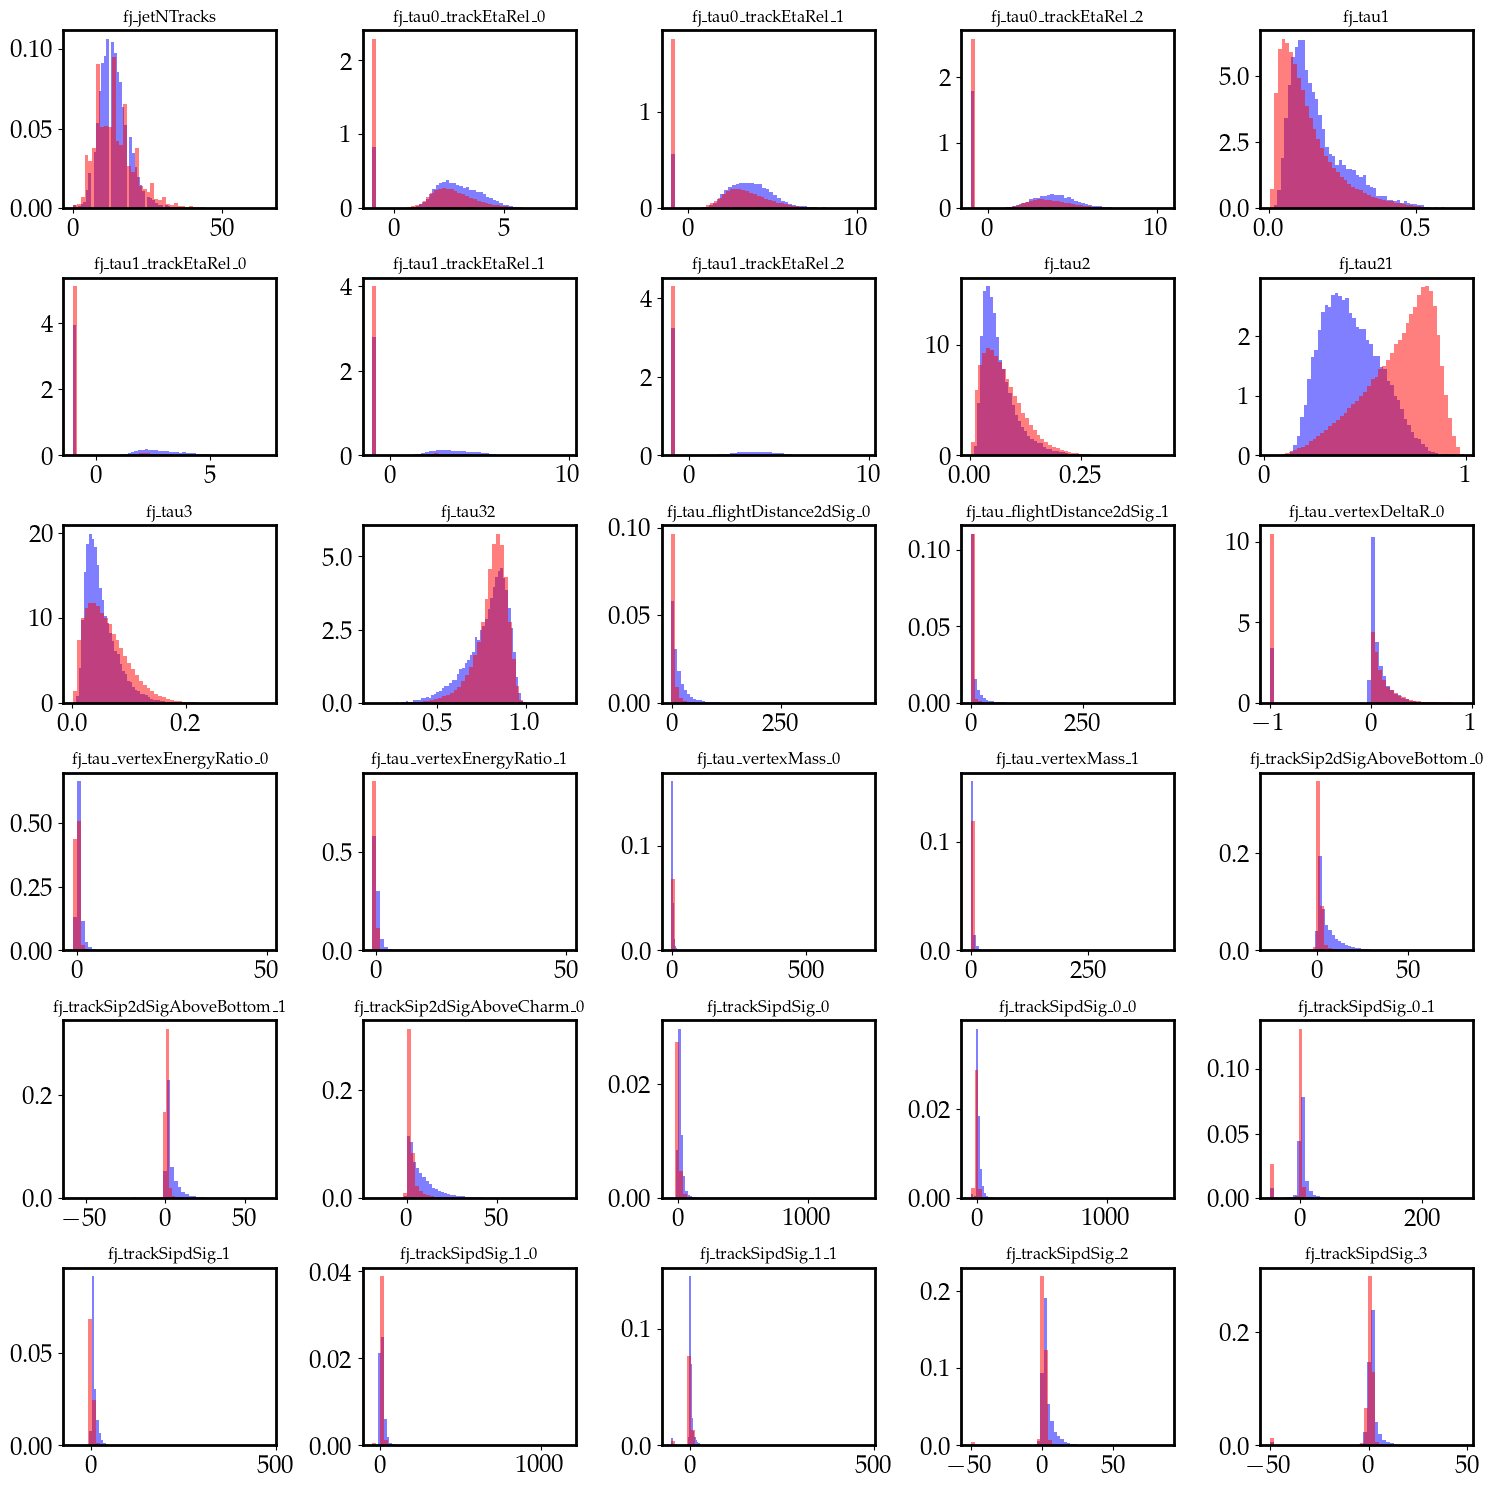

In [13]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in zip(axes.ravel(), df.columns.drop('fj_nSV')):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [14]:
df.corr()

,fj_jetNTracks,fj_nSV,fj_tau0_trackEtaRel_0,fj_tau0_trackEtaRel_1,fj_tau0_trackEtaRel_2,fj_tau1,fj_tau1_trackEtaRel_0,fj_tau1_trackEtaRel_1,fj_tau1_trackEtaRel_2,fj_tau2,...,fj_trackSip2dSigAboveBottom_1,fj_trackSip2dSigAboveCharm_0,fj_trackSipdSig_0,fj_trackSipdSig_0_0,fj_trackSipdSig_0_1,fj_trackSipdSig_1,fj_trackSipdSig_1_0,fj_trackSipdSig_1_1,fj_trackSipdSig_2,fj_trackSipdSig_3
fj_jetNTracks,1.000000,0.307993,0.135390,0.116688,0.135306,0.432317,0.174142,0.164755,0.159960,0.366259,...,0.247854,0.169764,0.066009,0.191389,0.402153,0.192641,0.096786,0.278350,0.288106,0.341982
fj_nSV,0.307993,1.000000,0.631955,0.606959,0.513551,0.230536,0.625341,0.611440,0.560883,0.157985,...,0.310372,0.359564,0.130503,0.154900,0.199567,0.269644,0.124320,0.167796,0.211881,0.168531
fj_tau0_trackEtaRel_0,0.135390,0.631955,1.000000,0.964755,0.595236,0.122846,0.299392,0.296544,0.242487,0.065341,...,0.174402,0.197003,0.078202,0.099110,0.127858,0.169129,0.074715,0.104815,0.144455,0.123906
fj_tau0_trackEtaRel_1,0.116688,0.606959,0.964755,1.000000,0.538414,0.104573,0.295528,0.292620,0.239296,0.041501,...,0.168406,0.192565,0.076198,0.094454,0.117269,0.161595,0.072015,0.097508,0.134457,0.113978
fj_tau0_trackEtaRel_2,0.135306,0.513551,0.595236,0.538414,1.000000,0.119603,0.191983,0.189840,0.154793,0.075237,...,0.154428,0.162162,0.064329,0.082269,0.114267,0.146265,0.061082,0.089565,0.130342,0.114666
fj_tau1,0.432317,0.230536,0.122846,0.104573,0.119603,1.000000,0.160216,0.150164,0.148105,0.811867,...,0.166223,0.104895,0.040068,0.121252,0.238041,0.123076,0.051101,0.138400,0.139498,0.149710
fj_tau1_trackEtaRel_0,0.174142,0.625341,0.299392,0.295528,0.191983,0.160216,1.000000,0.982653,0.770306,0.081571,...,0.213466,0.235637,0.084538,0.120687,0.157824,0.180244,0.076429,0.105675,0.135022,0.102263
fj_tau1_trackEtaRel_1,0.164755,0.611440,0.296544,0.292620,0.189840,0.150164,0.982653,1.000000,0.737085,0.070287,...,0.210200,0.232556,0.083254,0.120538,0.156419,0.176842,0.073663,0.101182,0.131873,0.099450
fj_tau1_trackEtaRel_2,0.159960,0.560883,0.242487,0.239296,0.154793,0.148105,0.770306,0.737085,1.000000,0.079031,...,0.193408,0.206813,0.073130,0.100607,0.131640,0.163592,0.068714,0.101631,0.122554,0.091533
fj_tau2,0.366259,0.157985,0.065341,0.041501,0.075237,0.811867,0.081571,0.070287,0.079031,1.000000,...,0.058636,0.009123,0.007105,0.068265,0.166832,0.060825,0.027303,0.110227,0.099587,0.123573


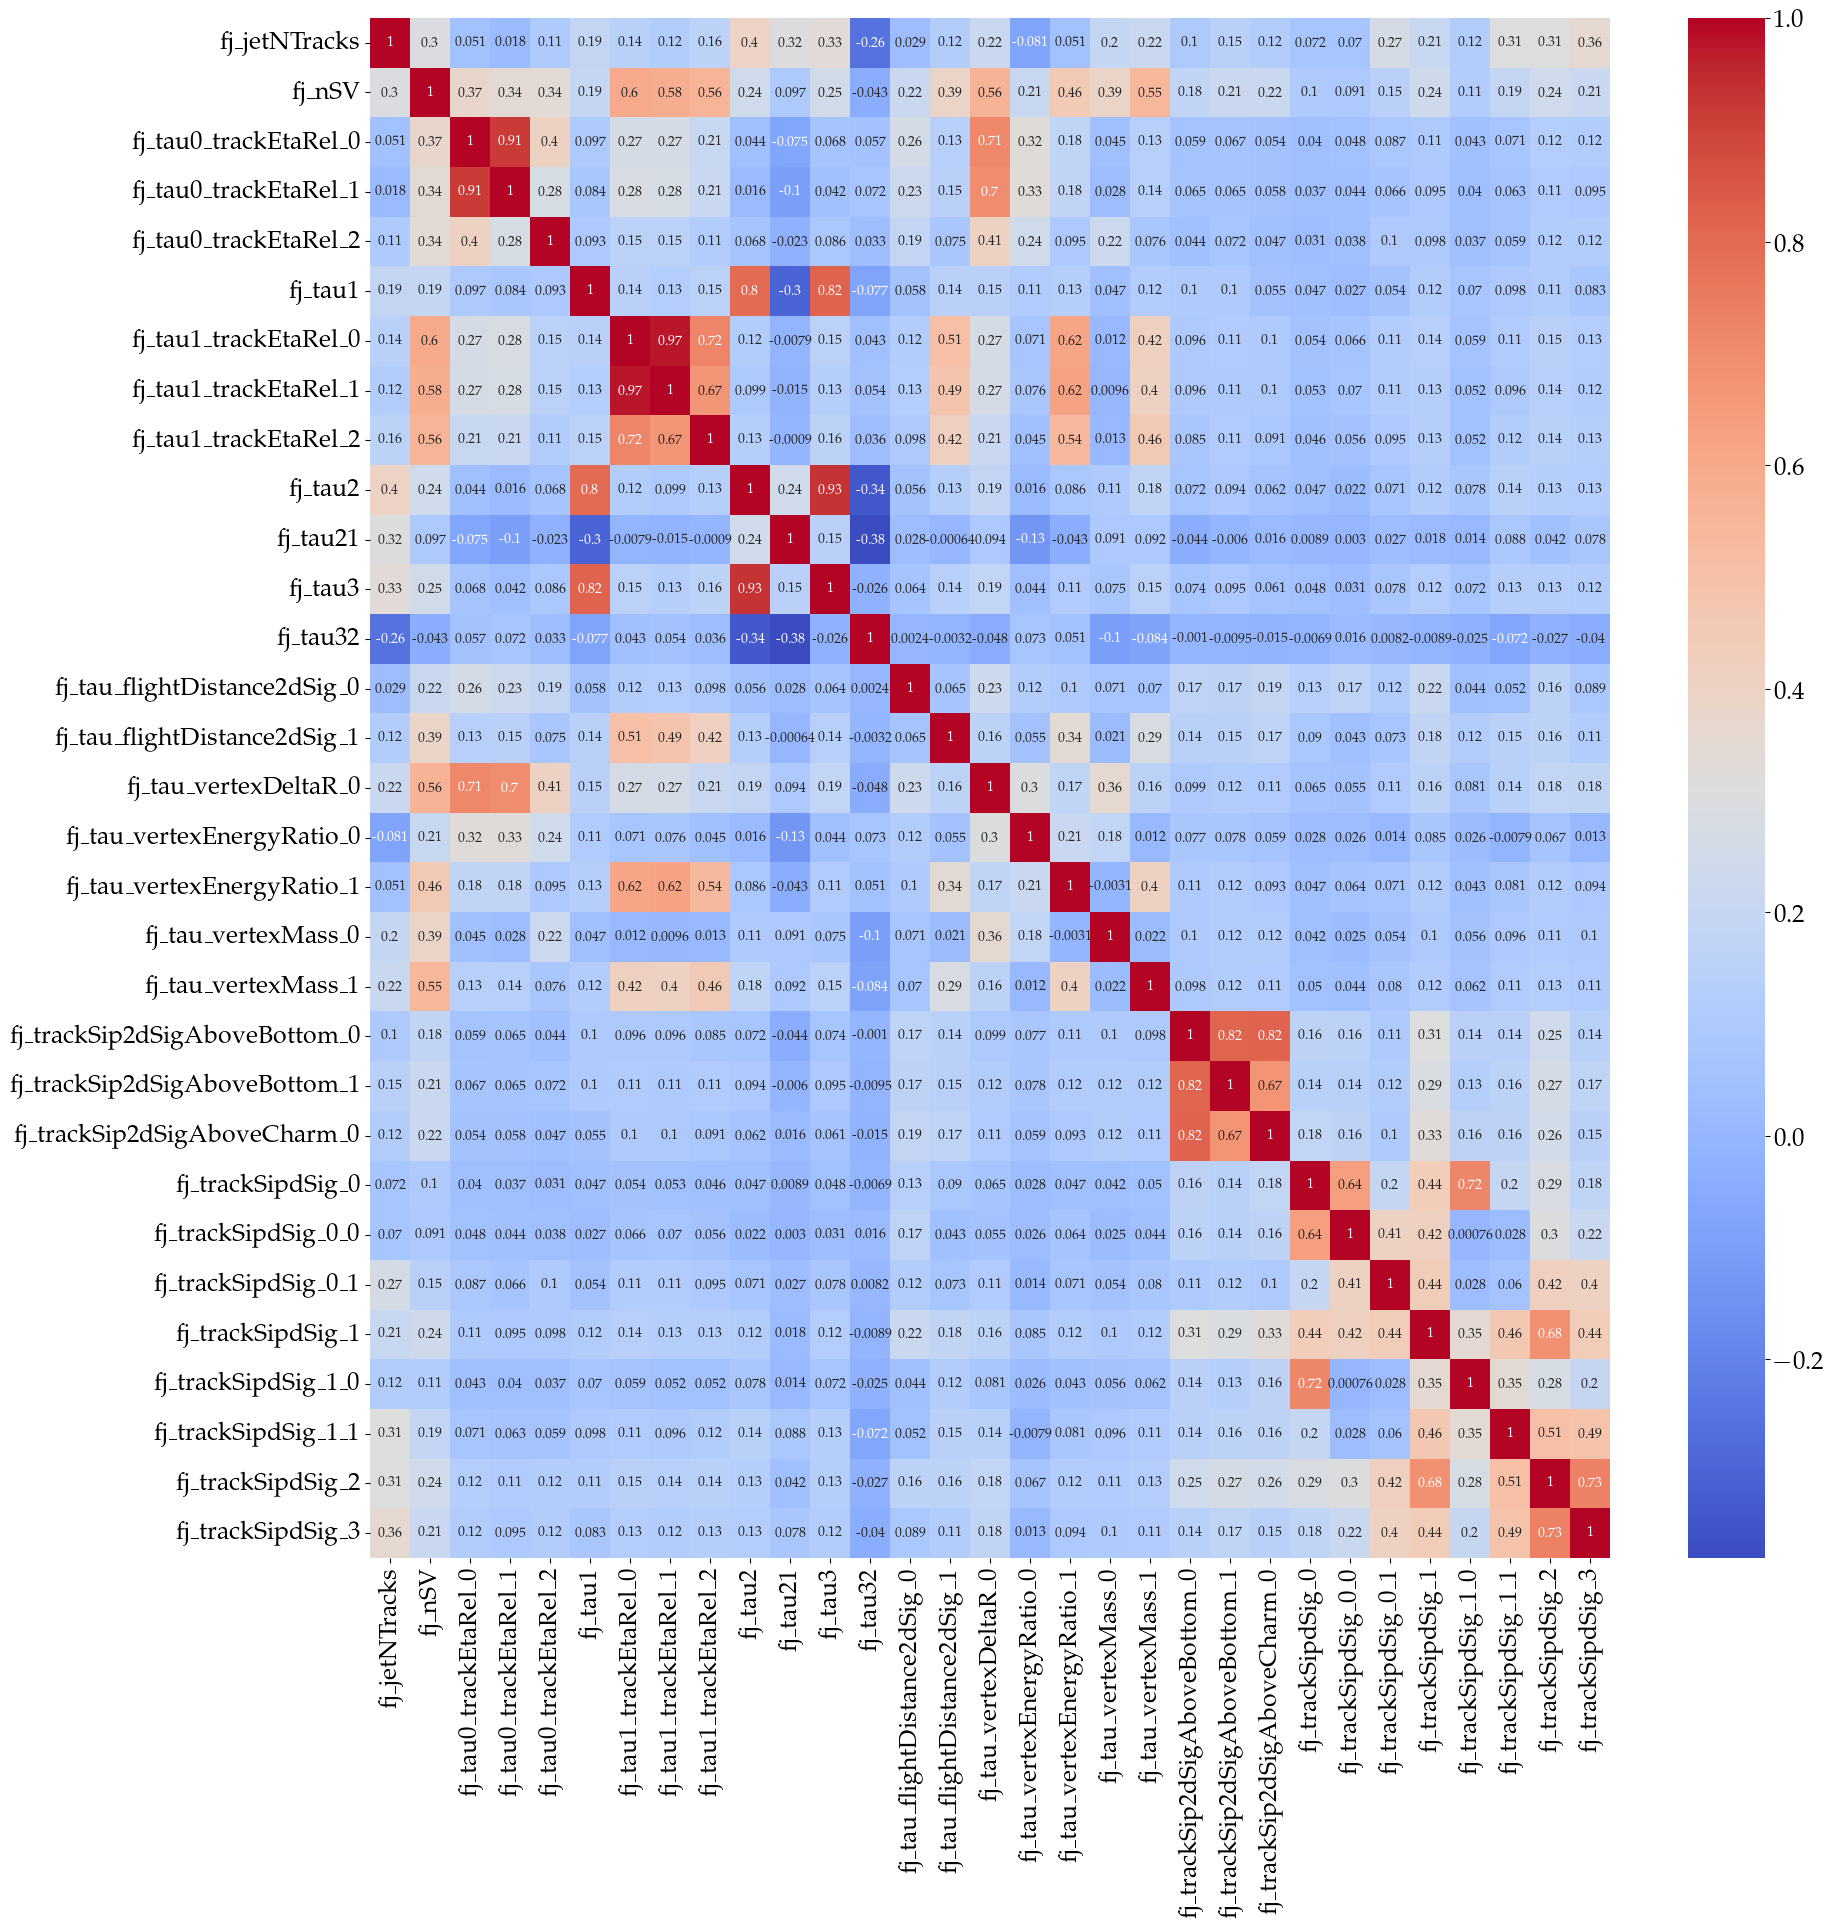

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True)
plt.show()

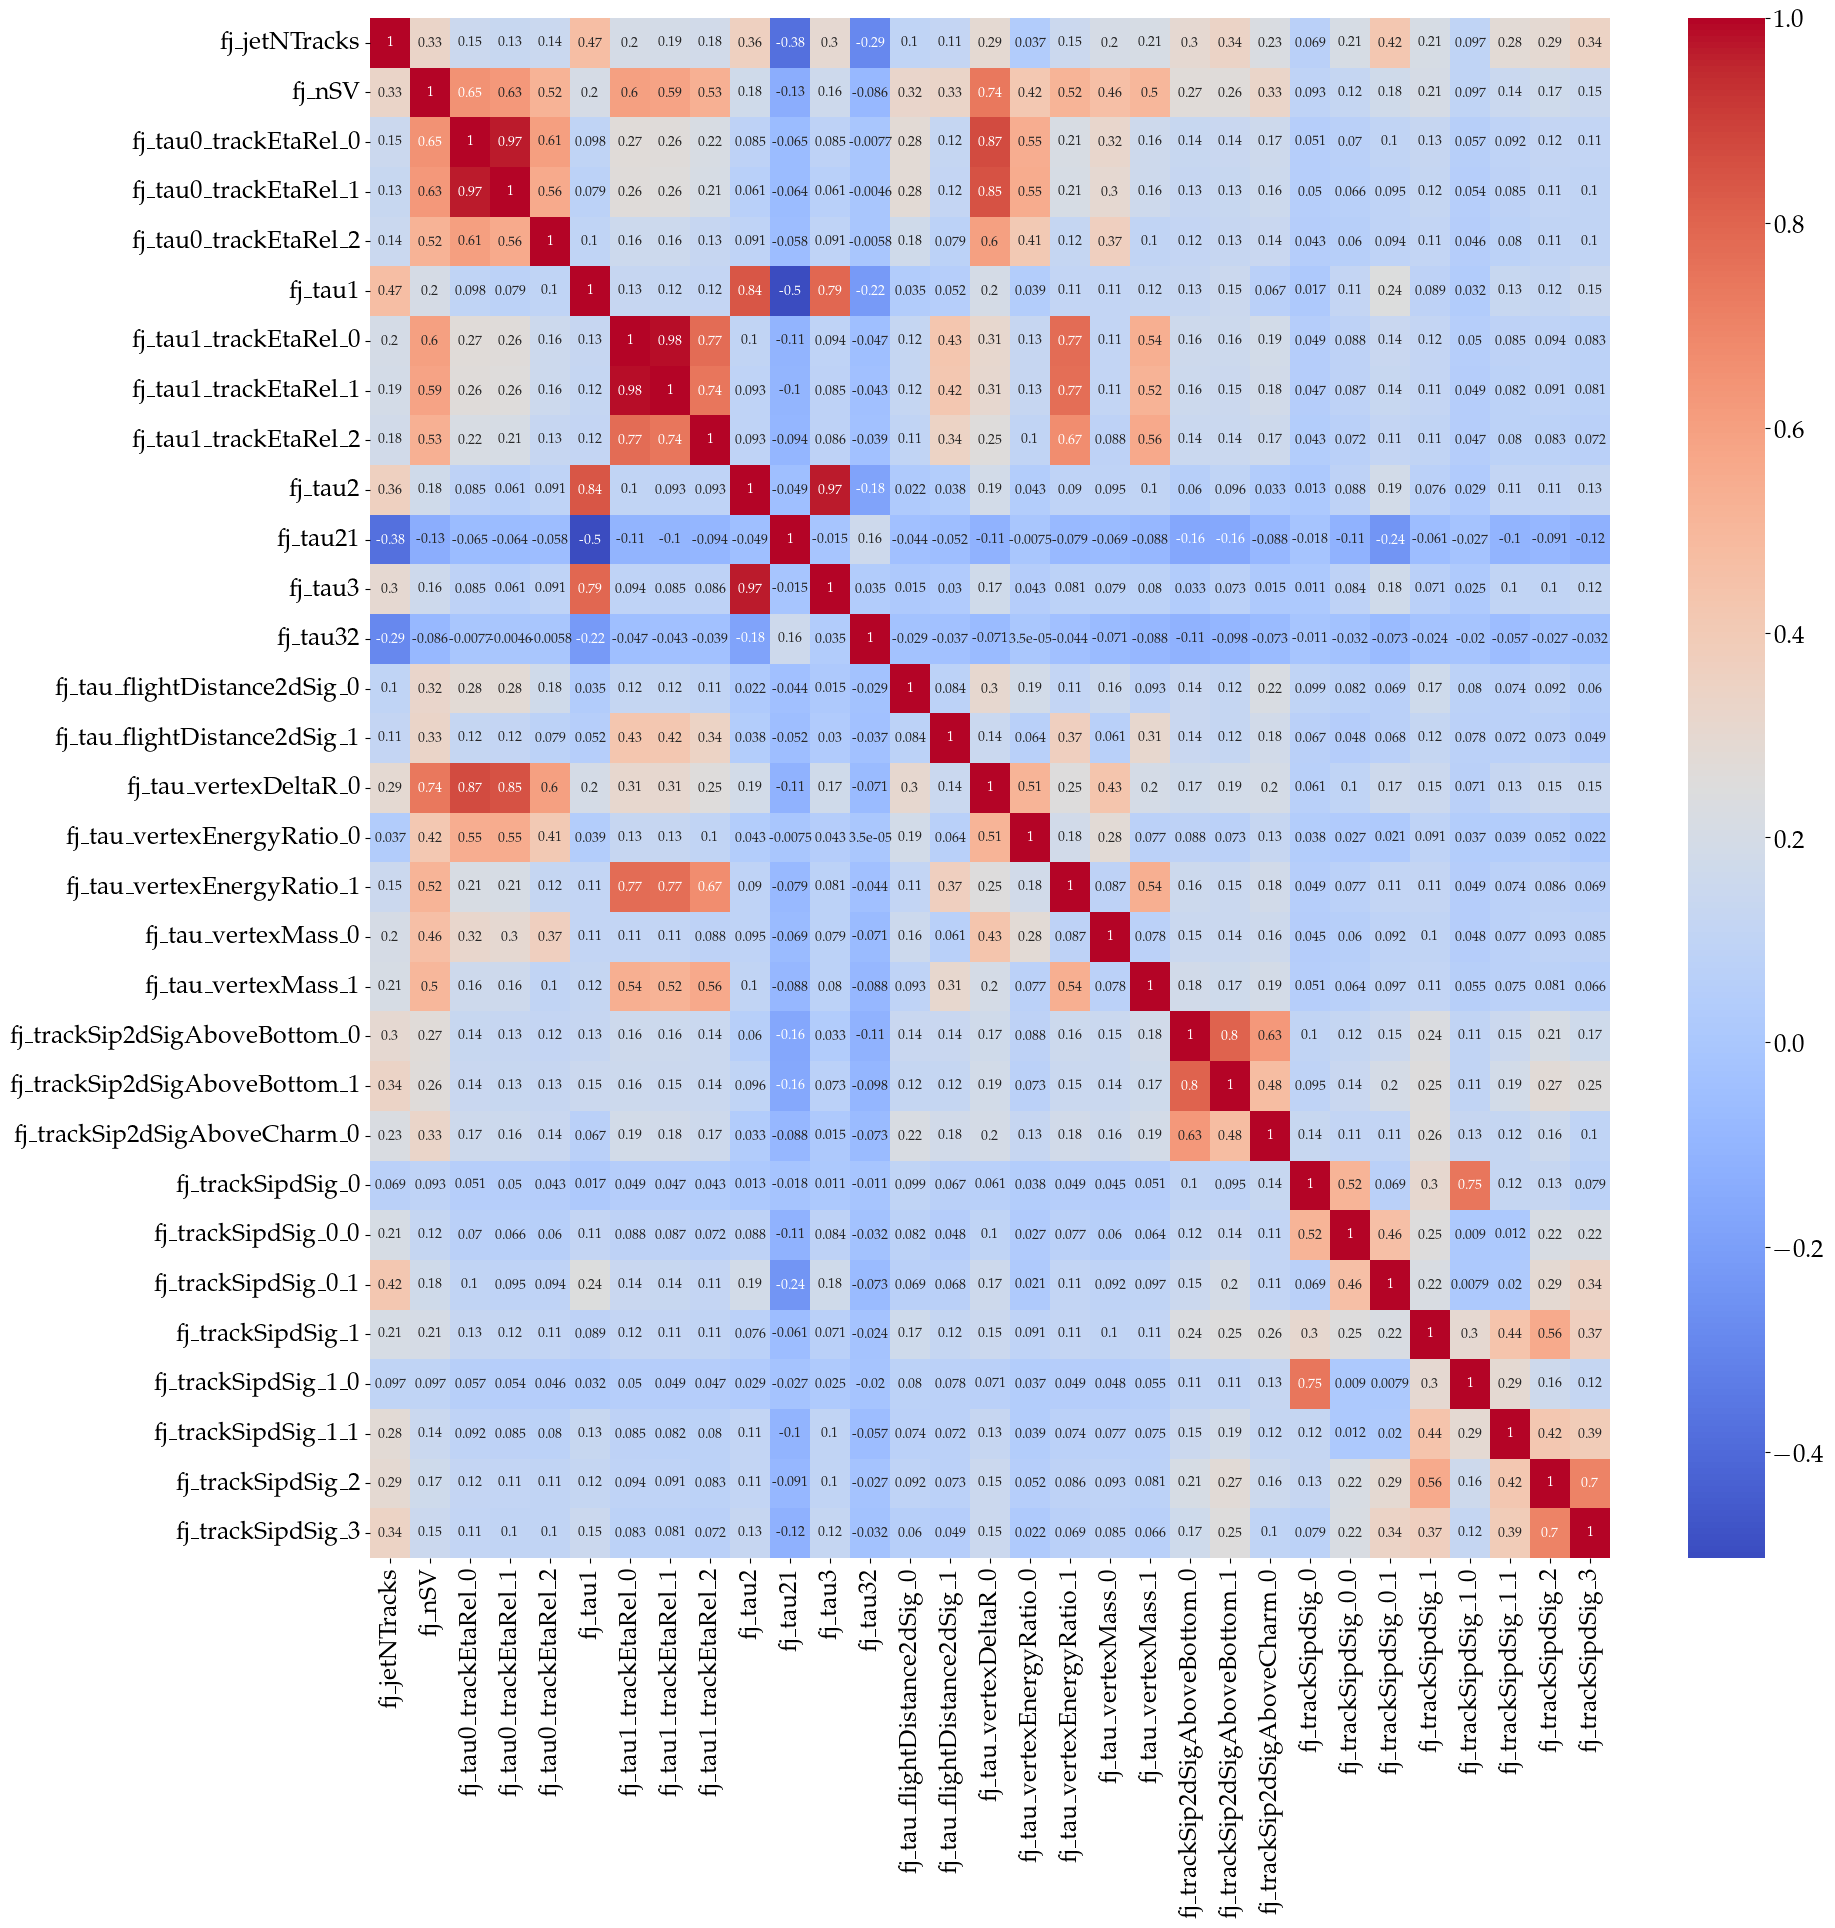

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True)
plt.show()

In [17]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [18]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

In [20]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [21]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

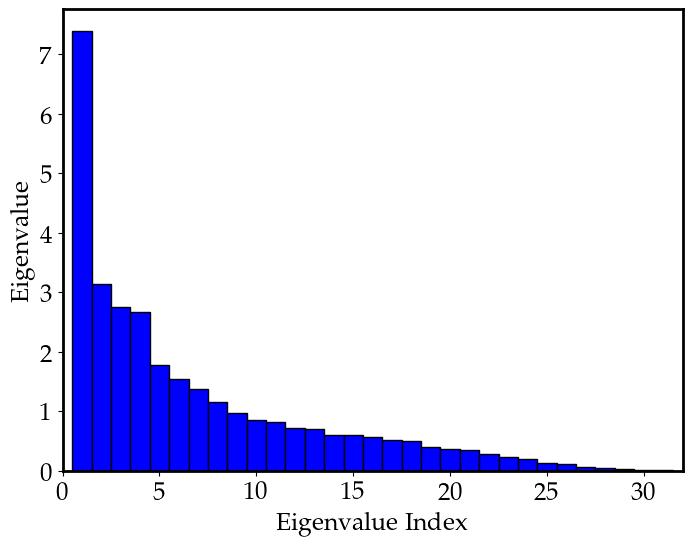

In [22]:
plt.figure(figsize=(8,6))
x = np.arange(1,32)
plt.xlim(0,32)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [23]:
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.23822144 0.10145371 0.08879871 0.08630551 0.05760003 0.04981406
 0.04449262 0.0374145  0.03146535 0.02768757 0.02631203 0.02351268
 0.02286498 0.01958311 0.01928105 0.01816837 0.01688961 0.01638093
 0.01293667 0.01187952 0.01152565 0.00936895 0.007581   0.00648016
 0.00433761 0.00398771 0.00201539 0.0017951  0.0010344  0.00050851
 0.00030307]
[0.23822144 0.33967515 0.42847386 0.51477937 0.5723794  0.62219346
 0.66668608 0.70410058 0.73556593 0.7632535  0.78956553 0.81307821
 0.83594318 0.8555263  0.87480735 0.89297572 0.90986532 0.92624626
 0.93918293 0.95106245 0.9625881  0.97195706 0.97953805 0.98601822
 0.99035583 0.99434354 0.99635892 0.99815402 0.99918842 0.99969693
 1.        ]
[1177.7172    768.572     719.04144   708.8753    579.1112    538.55066
  508.9728    466.73523   428.02277   401.50687   391.40628   369.9999
  364.86816   337.6692    335.05487   325.24347   313.58868   308.83032
  274.44913   262.99655   259.04987   233.55875   210.09406   194.24219
  158.91899   152

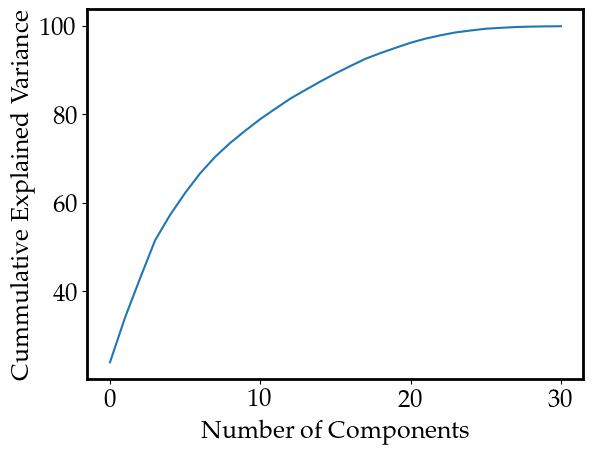

In [24]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [25]:
X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:10]
X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:10]

In [189]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [197]:
div = []
for i in features:
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

fj_tau21                         2.314211
fj_trackSip2dSigAboveBottom_0    1.492424
fj_trackSip2dSigAboveCharm_0     1.241116
fj_trackSip2dSigAboveBottom_1    1.134160
fj_tau_flightDistance2dSig_0     0.952063
fj_trackSipdSig_1                0.950319
fj_trackSipdSig_0                0.915236
fj_tau_vertexEnergyRatio_0       0.764415
fj_tau1                          0.758582
fj_trackSipdSig_0_0              0.708027
fj_nSV                           0.691918
fj_trackSipdSig_2                0.688521
fj_tau_vertexEnergyRatio_1       0.609577
fj_trackSipdSig_0_1              0.606431
fj_tau_vertexDeltaR_0            0.595188
fj_tau0_trackEtaRel_0            0.500907
fj_tau_flightDistance2dSig_1     0.497488
fj_tau0_trackEtaRel_1            0.488516
fj_tau1_trackEtaRel_1            0.447716
fj_tau1_trackEtaRel_0            0.442968
fj_trackSipdSig_3                0.410757
fj_trackSipdSig_1_0              0.409363
fj_trackSipdSig_1_1              0.314754
fj_tau1_trackEtaRel_2            0

In [28]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        label_col_name - name of y-label. Change to whatever your model has it named. Default 'label'.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.close()
    return fig

In [29]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(Dense(units=32,activation='relu',input_dim=10))
keras_model.add(Dense(units=32,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,474
Trainable params: 1,474
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# fit keras model
keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=1024, 
                epochs=100, validation_split=0.2)

Epoch 1/100


2022-10-16 22:16:59.391284: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


147/147 [==============================] - 0s 1ms/step - loss: 0.2963 - accuracy: 0.8789 - val_loss: 0.2280 - val_accuracy: 0.9061
Epoch 2/100
147/147 [==============================] - 0s 998us/step - loss: 0.2146 - accuracy: 0.9127 - val_loss: 0.2032 - val_accuracy: 0.9177
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1972 - accuracy: 0.9187 - val_loss: 0.1945 - val_accuracy: 0.9212
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1914 - accuracy: 0.9209 - val_loss: 0.1906 - val_accuracy: 0.9215
Epoch 5/100
147/147 [==============================] - 0s 994us/step - loss: 0.1884 - accuracy: 0.9220 - val_loss: 0.1882 - val_accuracy: 0.9228
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1859 - accuracy: 0.9231 - val_loss: 0.1871 - val_accuracy: 0.9233
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1842 - accuracy: 0.9238 - val_loss: 0.1849 - val_accuracy: 0.9242
Epoch 8

Epoch 58/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1692 - accuracy: 0.9298 - val_loss: 0.1745 - val_accuracy: 0.9285
Epoch 59/100
147/147 [==============================] - 0s 993us/step - loss: 0.1694 - accuracy: 0.9303 - val_loss: 0.1742 - val_accuracy: 0.9286
Epoch 60/100
147/147 [==============================] - 0s 964us/step - loss: 0.1692 - accuracy: 0.9303 - val_loss: 0.1758 - val_accuracy: 0.9280
Epoch 61/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1692 - accuracy: 0.9304 - val_loss: 0.1739 - val_accuracy: 0.9283
Epoch 62/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1691 - accuracy: 0.9302 - val_loss: 0.1743 - val_accuracy: 0.9289
Epoch 63/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1689 - accuracy: 0.9304 - val_loss: 0.1743 - val_accuracy: 0.9287
Epoch 64/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1690 - accuracy: 0.9305 - val_loss: 0.1737 - val_accur

In [31]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

5873/5873 [==============================] - 1s 247us/step


In [32]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

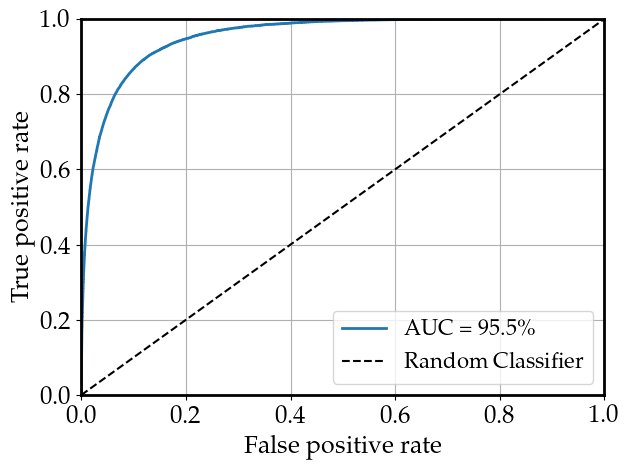

In [33]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [34]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0], y_test.to_numpy()[:,0], predict_array_test[:,0])

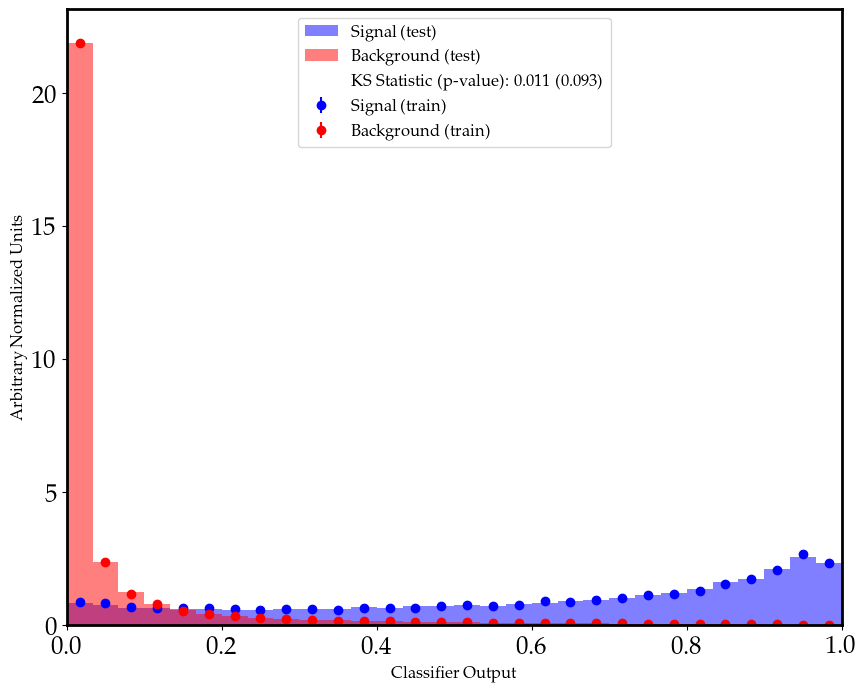

In [35]:
fig